In [ ]:
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR  # or any other scheduler you prefer

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Extract dataset.zip

In [ ]:
from google.colab import drive
import zipfile

# Step 2: Extract the zip file using absolute paths
zip_file_path = '/content/drive/MyDrive/AUTO EVAL/dataset.zip'
destination_dir = '/content/drive/MyDrive/AUTO EVAL/dataset-grayscale'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

In [ ]:
train_dir = "/content/drive/MyDrive/AUTO EVAL/dataset-grayscale/train"
test_dir = "/content/drive/MyDrive/AUTO EVAL/dataset-grayscale/test"
train_dir, test_dir

('/content/drive/MyDrive/AUTO EVAL/dataset-grayscale/train',
 '/content/drive/MyDrive/AUTO EVAL/dataset-grayscale/test')

### Data augmentation using _torchvision.transforms_
torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation :



*   Resize the image to 64x64
*   Apply random augmentations
*   Convert the images to tensors




In [ ]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### Loading image data using ImageFolder

In [ ]:
from torchvision import datasets
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 600
     Root location: /content/drive/MyDrive/AUTO EVAL/dataset-grayscale/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: /content/drive/MyDrive/AUTO EVAL/dataset-grayscale/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
class_names = train_data_augmented.classes
class_names

['false', 'none', 'true']

### Turning our Dataset into DataLoader's to make them iterable

In [ ]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7915183afeb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7915183aee60>)

### Download helper functions from github repo

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### Device agnostic code setup

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'


### Create training and testing loop

#### train_step() - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader
#### test_step() - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
#### train() - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        if scheduler:
            scheduler.step()
            print(f"Epoch: {epoch+1} | Current LR: {scheduler.get_last_lr()[0]:.6f}")


        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### TinyVGG CNN Model

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),  # Add BatchNorm here
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),  # Add BatchNorm here
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),  # Add BatchNorm here
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),  # Add BatchNorm here
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

# Create model_2 and send it to the target device
torch.manual_seed(42)
model_2 = TinyVGG(
    input_shape=3,
    hidden_units=25,
    output_shape=len(train_data_augmented.classes)).to(device)
model_2

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0):

### Train and Evaluate model_2

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 80

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_2
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1 | Current LR: 0.000900
Epoch: 1 | train_loss: 1.3796 | train_acc: 0.4600 | test_loss: 1.0666 | test_acc: 0.3375
Epoch: 2 | Current LR: 0.000810
Epoch: 2 | train_loss: 1.0194 | train_acc: 0.5291 | test_loss: 0.8331 | test_acc: 0.6892
Epoch: 3 | Current LR: 0.000729
Epoch: 3 | train_loss: 0.9568 | train_acc: 0.5543 | test_loss: 0.9344 | test_acc: 0.4955
Epoch: 4 | Current LR: 0.000656
Epoch: 4 | train_loss: 0.9450 | train_acc: 0.5817 | test_loss: 0.8044 | test_acc: 0.5960
Epoch: 5 | Current LR: 0.000590
Epoch: 5 | train_loss: 0.9607 | train_acc: 0.5543 | test_loss: 0.6753 | test_acc: 0.7045
Epoch: 6 | Current LR: 0.000531
Epoch: 6 | train_loss: 0.8701 | train_acc: 0.5762 | test_loss: 0.8063 | test_acc: 0.5852
Epoch: 7 | Current LR: 0.000478
Epoch: 7 | train_loss: 0.9157 | train_acc: 0.5548 | test_loss: 0.6389 | test_acc: 0.7261
Epoch: 8 | Current LR: 0.000430
Epoch: 8 | train_loss: 0.7949 | train_acc: 0.6086 | test_loss: 0.6085 | test_acc: 0.7585
Epoch: 9 | Current LR: 0.000387


In [ ]:
model_2_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

### Evaluate the model by plotting the loss curves

In [ ]:
def plot_loss_curves(results : dict[str, list[float]]):

  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15, 7))

  #plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label = 'train_loss')
  plt.plot(epochs, test_loss, label = 'test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label = 'train_acc')
  plt.plot(epochs, test_accuracy, label = 'test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

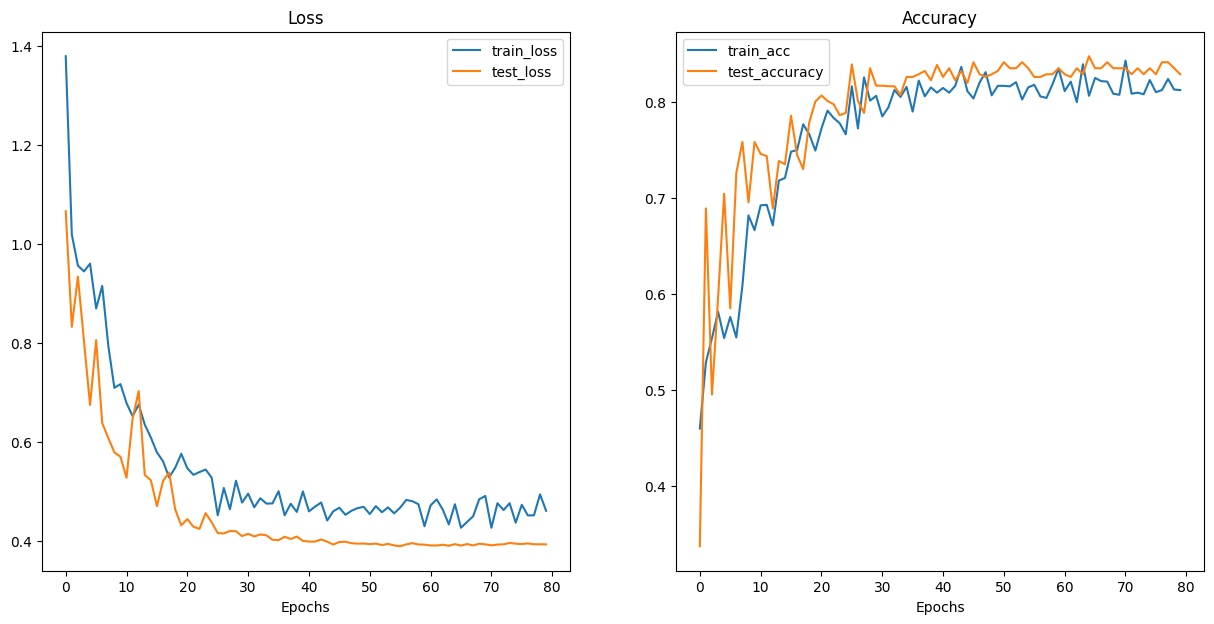

In [ ]:
plot_loss_curves(model_2_results)

### Save the model

In [ ]:
model_path = "TINYVGG-GRAY-test_acc-82.90-train_acc-81.25.pth"
torch.save(model_2.state_dict(), model_path)

In [ ]:
# from google.colab import files
# files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>